# Exploring OSM building heigh data

In [1]:
import ast
import folium
import numpy as np
import osmnx as ox 
import utm
from typing import List
import geopandas as gpd

/home/wrfadmin/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Settings

In [2]:
# Bounding box
south, east, north, west = (51.3435, 12.5023, 51.6020, 11.4419)

In [3]:
border = gpd.read_file('halle.geojson')

In [4]:
border.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Obtaining the buildings from OSM

In [5]:
buildings = ox.geometries_from_bbox(north, south, east, west, tags = {'building': True})

In [6]:
cols = ['geometry', 'building', 'building:levels', 'height'] 
buildings = buildings[cols]

In [7]:
buildings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Data subset

In [8]:
buildings = gpd.clip(buildings, border)

In [9]:
# Remove incomplete geometries
# See note "To get only the actual geometry objects that are neither missing nor empty, you can use a combination of both"
# in https://geopandas.org/en/stable/docs/user_guide/missing_empty.html
buildings = buildings[~buildings.geometry.is_empty & ~buildings.geometry.isna()]

In [10]:
buildings.head()

geometry  \
element_type osmid                                                          
way          200420939  POLYGON ((12.00298 51.42138, 12.00294 51.42135...   
             340413643  POLYGON ((12.00314 51.42146, 12.00304 51.42140...   
             200420927  POLYGON ((12.00278 51.42138, 12.00273 51.42140...   
             200420908  POLYGON ((12.00308 51.42149, 12.00299 51.42143...   
             200420907  POLYGON ((12.00279 51.42163, 12.00284 51.42161...   

                       building building:levels height  
element_type osmid                                      
way          200420939      yes             NaN    NaN  
             340413643      yes             NaN    NaN  
             200420927      yes             NaN    NaN  
             200420908      yes             NaN    NaN  
             200420907      yes             NaN    NaN

In [11]:
# Keep only geometries consisting of polygons
buildings = buildings[buildings.geometry.geom_type=='Polygon']

## Buildings data overview

In [12]:
buildings.count()

geometry           40606
building           40606
building:levels     8246
height                80
dtype: int64

In [13]:
with open('building_osm.geojson' , 'w') as file:
    file.write(buildings.to_json())

## Total buldings

In [14]:
total_buildings = len(buildings)

In [15]:
print(f'Total OSM buildings: {total_buildings}')

Total OSM buildings: 40606


## Total buildings missing heights

In [16]:
missing_heights = buildings[buildings.height.isnull()]

In [17]:
# Total missing heights
len(missing_heights)

40526

## Buildings missing levels

In [18]:
# Total missing levels
missing_levels = buildings[buildings['building:levels'].isnull()]

In [19]:
len(missing_levels)

32360

## Buildings missing levels and missing heights

In [20]:
missing_both = buildings[(buildings.height.isnull()) & (buildings['building:levels'].isnull())]

In [21]:
len(missing_both)

32332

In [22]:
len(buildings) - len(missing_both)

8274

## Buildings with levels and height data

In [23]:
having_both = buildings[(~buildings.height.isnull()) & (~buildings['building:levels'].isnull())]

In [24]:
having_both.head()

geometry  \
element_type osmid                                                         
way          97689009  POLYGON ((11.97551 51.43883, 11.97566 51.43885...   
             97689033  POLYGON ((11.97547 51.43894, 11.97562 51.43896...   
             97689053  POLYGON ((11.97543 51.43904, 11.97559 51.43906...   
             97689019  POLYGON ((11.97539 51.43915, 11.97555 51.43917...   
             97689064  POLYGON ((11.97535 51.43925, 11.97551 51.43927...   

                      building building:levels height  
element_type osmid                                     
way          97689009      yes               5     16  
             97689033      yes               5     16  
             97689053      yes               5     16  
             97689019      yes               5     16  
             97689064      yes               5     16

In [25]:
len(having_both.index)

52

In [26]:
having_both.height.unique()

array(['16', '30', '2.5', '11', '6', '18', '20', '44', '22', '10', '24',
       '11.5', '54', '3', '5', '9', '51'], dtype=object)

## Kind of building

In [27]:
buildings.building.unique()

array(['yes', 'parking', 'apartments', 'detached', 'garage',
       'construction', 'garages', 'school', 'house', 'grandstand',
       'retail', 'allotment_house', 'semidetached_house', 'church',
       'residential', 'industrial', 'commercial', 'terrace', 'roof',
       'kindergarten', 'warehouse', 'office', 'supermarket', 'shed',
       'service', 'government', 'public', 'chapel', 'kiosk', 'stadium',
       'bungalow', 'boathouse', 'prefabricated', 'hut', 'dormitory',
       'ruins', 'greenhouse', 'hospital', 'civic', 'barn',
       'sports_centre', 'transformer_tower', 'abandoned', 'signal_box',
       'train_station', 'hotel', 'mosque', 'sports_hall', 'university',
       'stable', 'concert_hall', 'bridge', 'carport', 'water_tower',
       'synagogue', 'transportation', 'depot', 'tent', 'toilets',
       'social_facility', 'no', 'farm_auxiliary'], dtype=object)

In [28]:
buildings[buildings.building=='yes'].count()

geometry           26494
building           26494
building:levels      848
height                39
dtype: int64

## Summary

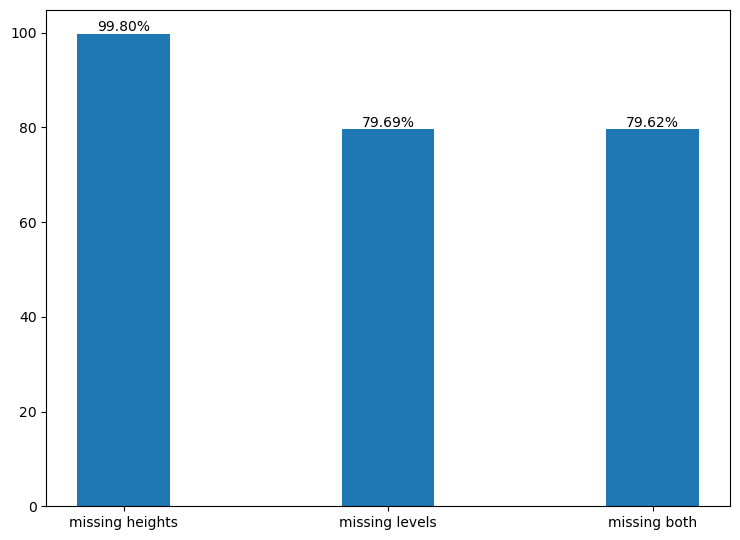

In [29]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True

x = ['missing heights', 'missing levels', 'missing both']
y = [len(missing_heights)/total_buildings*100.0, 
     len(missing_levels)/total_buildings*100.0, 
     len(missing_both)/total_buildings*100.0]

width = 0.35
fig, ax = plt.subplots()

pps = ax.bar(x, y, width, align='center')

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+.50,
      s=f"{height:.2f}%",
      ha='center')

plt.show()